# Subject 67 - Invariant Risk Minimization

In [228]:
import numpy as np
from sklearn.linear_model import LinearRegression

## Introduction

This notebook presents essential results studied in the article **Invariant Risk Minimization** that can be found at https://arxiv.org/pdf/1907.02893.pdf.
Because most machine learning algorithms depend on the assumption that training and testing data are sampled independently from the same distribution, it is common practice to shuffle at random the training and testing sets. Nevertheless, this article suggests this is not always the best solution, in fact the origin of your data can contain some useful details and shuffling between all of them can discard some information. To adress this issue, the authors purpose another way of training model.

Before introucing this new idea, let's see first what can go wrong with traditional machine learning model through an example:

### First one : an abstract one

Suppose you are working on an image classification task and you want to determine for each images whether it is a cow image or a camel one. Owing a set of images like the ones below you will surely train a CNN to deal with this task.
<table><tr>
<td> <img src="images/vache1.jpg" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="images/chameau1.jpg" alt="Drawing" style="width: 300px;"/> </td>
</tr></table>
<table><tr>
<td> <img src="images/vache2.jpg" alt="Drawing" style="width: 300px;"/> </td>
<td> <img src="images/chameau2.jpg" alt="Drawing" style="width: 300px;"/> </td>
</tr></table>

Unfortunately it is much probable that your neural network fails to classify such image :
<table><tr>
<td> <img src="images/vache_desert.jpeg" alt="Drawing" style="width: 300px;"/> </td>
</tr></table>

### Second one : a more concrete example

We consider here the three following random variables defined on a set of some environnement $e\in\xi_{all} $ as :
$$$$
$$X_1^e \sim \mathcal{N}(0,\,\sigma^{2}_e)$$
$$Y^e \sim X_1^e + \mathcal{N}(0,\,\sigma^{2}_e)$$
$$X_2^e \sim Y^e + \mathcal{N}(0,\,1)$$
$$$$
where $\xi_{all} $ denotes the set of all possible/existing envoironnement.
$$$$

According to you, what will happen if we decide to predict $Y$, knowing $X_1$ and $X_2$ ?

$$$$
Just before pursuing this case, let's compute now some statistics about these random variables which will be useful later :

$\sigma^2(X_1^e)=\sigma^{2}_e$,

$\sigma^2(Y^e)=2\sigma^{2}_e$,

$\sigma^2(X_2^e)=2\sigma^{2}_e+1$,

$\sigma(X_1^e,Y^e)=\sigma^{2}_e$,

$\sigma(X_2^e,Y^e)=2\sigma^{2}_e$,

$\sigma^2(X_1^e,X_2^e)=\sigma^{2}_e$


In order to predict $Y$, we will consider the three different linear regressions : $Y^e=aX_1^e+c$, $Y^e=bX_2^e+c$ and $Y^e=aX_1^e+bX_2^e+c$ and realize each regression on two distinct environnements.

In [6]:
#Define our random variables on two different environnements

n = 10000 # number of samples for each environnement 

sigma1 = 10 # variance for the environnement 1 noise 
X1e1 = np.random.normal(0,sigma1,n).reshape(-1,1)
Ye1 = X1e1 + np.random.normal(0,sigma1,n).reshape(-1,1)
X2e1 = Ye1 + np.random.normal(0,1,n).reshape(-1,1)

sigma2 = 0.1 # variance for the environnement 2 noise 
X1e2 = np.random.normal(0,sigma2,n).reshape(-1,1)
Ye2 = X1e2 + np.random.normal(0,sigma2,n).reshape(-1,1)
X2e2 = Ye2 + np.random.normal(0,1,n).reshape(-1,1)

In [7]:
def regressor(Y, Xs):
    lr = LinearRegression()
    lr.fit(np.concatenate(Xs, axis=1),Y)
    return lr.coef_[0]

In [8]:
reg1_env1 = regressor(Ye1,[X1e1])
reg2_env1 = regressor(Ye1,[X2e1])
reg3_env1 = regressor(Ye1,[X1e1,X2e1])

reg1_env2 = regressor(Ye2,[X1e2])
reg2_env2 = regressor(Ye2,[X2e2])
reg3_env2 = regressor(Ye2,[X1e2,X2e2])

In [9]:
print("By running such regressions (despite different environnements), one might naively expect to \nhave quite the same results for each pair of regressions on both environnement but this is not \nthe case. \nFor the first regression we obtain %f as coefficient on environnement 1 and %f \non environnement 2.\nFor the second regression we obtain %f as coefficient on environnement 1 and %f \non environnement 2.\nFor the third regression we obtain the couple (%f, %f) as coefficients on \nenvironnement 1 and (%f, %f) on environnement 2." % (reg1_env1, reg1_env2, reg2_env1, reg2_env2, reg3_env1[0], reg3_env1[1], reg3_env2[0], reg3_env2[1]))

By running such regressions (despite different environnements), one might naively expect to 
have quite the same results for each pair of regressions on both environnement but this is not 
the case. 
For the first regression we obtain 0.996474 as coefficient on environnement 1 and 1.004092 
on environnement 2.
For the second regression we obtain 0.995075 as coefficient on environnement 1 and 0.018855 
on environnement 2.
For the third regression we obtain the couple (0.009765, 0.990180) as coefficients on 
environnement 1 and (0.994990, 0.009961) on environnement 2.


In our study case, only the regression $Y^e=aX_1^e+c$ has given the same result on both environnement, let's see more in detail why we obtained these result.

Our linear regressor as it is defined solve the Least Square Criterion $$min \frac1n\sum\limits_{k=1}^n(y_k-a_1X_1-...-a_mX_m+b)^2$$
$$$$
The calculation of the annulation point of the gradient (with respect to $(a_i)_i,b$) gives :
$$$$
$$\begin{cases}
a_1\sigma^2(x_1)  &=\sigma(x_1,y) \\
b &=\bar{y}-a_1\bar{x_1}
\end{cases}\leftrightarrow\begin{cases}
a_1  &=\frac{\sigma(x_1,y)}{\sigma^2(x_1)} \\
b &=\bar{y}-a_1\bar{x_1} \\
\end{cases}$$ for the 1D case 
and : 
$$$$
$$\begin{cases}
a_1\sigma^2(x_1) + a_2\sigma(x_1,x_2)  &=\sigma(x_1,y) \\
a_1\sigma(x_1,x_2) + a_2\sigma^2(x_2)  &=\sigma(x_2,y) \\
b &=\bar{y}-a_1\bar{x_1}-a_2\bar{x_2} \\
\end{cases}\leftrightarrow\begin{cases}
a_1  &=\frac{\sigma^2(x_2)\sigma(x_1,y)-\sigma(x_1,x_2)\sigma(x_2,y)}{\sigma^2(x_1)\sigma^2(x_2)-\sigma(x_1,x_2)^2} \\
a_2  &=\frac{\sigma^2(x_1)\sigma(x_2,y)-\sigma(x_1,x_2)\sigma(x_1,y)}{\sigma^2(x_1)\sigma^2(x_2)-\sigma(x_1,x_2)^2} \\
b &=\bar{y}-a_1\bar{x_1}-a_2\bar{x_2} \\
\end{cases}$$ for the 2D case 





Using these results on our original regressions gives the following analytical solutions :

Coefficients for the three regressions are respectively $1, \frac{\sigma^2_e}{\sigma^2_e+0.5}$ and $(\frac{1}{\sigma^2_e+1},\frac{\sigma^2_e}{\sigma^2_e+1})$


### Test

(-1.0, 12.0)

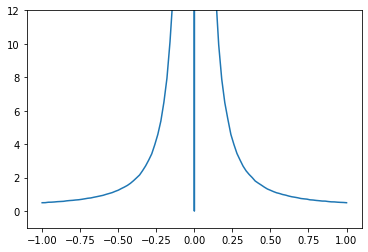

In [251]:
Ddist = []
C =  np.linspace(-1, 1, 101)
w  = np.array([1,0])
n = 100000
sigma=1

for c in C:
    X1 = np.random.normal(0,sigma,n).reshape(-1,1)
    Y = X1 + np.random.normal(0,sigma, n).reshape(-1,1)
    X2 = Y + np.random.normal(0,1,n).reshape(-1,1)
    
    X=np.concatenate([X1,X2], axis=1)
    phi = np.array([[1, 0],
                   [0, c]])
    
    lr = LinearRegression(fit_intercept=False)
    lr.fit(X@phi, Y)
    x = lr.coef_
    Ddist.append(((x-w)**2).sum())

plt.plot(C, Ddist)
plt.ylim(-1, 12)

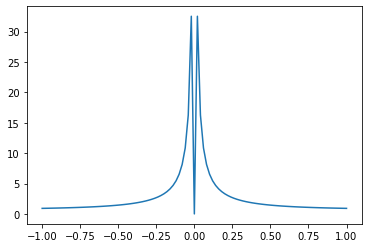

In [249]:
from sklearn.linear_model import Ridge

def ls(x, y, reg=1):
    return Ridge(alpha=reg, fit_intercept=False).fit(x, y).coef_


def sample(n=100000, e=1):
    x = np.random.randn(n, 1) * e
    y = x + np.random.randn(n, 1) * e
    z = y + np.random.randn(n, 1)
    return np.hstack((x, z)), y


def penalty_ls(x1, y1, x2, y2, t=1, reg=0):
    phi = np.diag([1, t])
    w = np.array([1, 0]).reshape(1, 2)
    p1 = np.linalg.norm(ls(x1 @ phi, y1, reg) - w) 
    p2 = np.linalg.norm(ls(x2 @ phi, y2, reg) - w)
    return (p1 + p2) / 2


def penalty_g(x1, y1, x2, y2, t=1):
    phi = np.diag([1, t])
    w = np.array([1, 0]).reshape(2, 1)
    p1 = (phi.T @ x1.T @ x1 @ phi @ w - phi.T @ x1.T @ y1) / x1.shape[0]
    p2 = (phi.T @ x2.T @ x2 @ phi @ w - phi.T @ x2.T @ y2) / x2.shape[0]
    return np.linalg.norm(p1) ** 2 + np.linalg.norm(p2) ** 2



x1, y1 = sample(e=1)
x2, y2 = sample(e=2)

plot_x = np.linspace(-1, 1, 100 + 1)
plot_y_ls = []
plot_y_ls_reg = []
plot_y_1 = []

for t in plot_x:
    plot_y_ls.append(penalty_ls(x1, y1, x2, y2, t))
    plot_y_ls_reg.append(penalty_ls(x1, y1, x2, y2, t, reg=1000))
    plot_y_1.append(penalty_g(x1, y1, x2, y2, t))
    
plt.plot(plot_x, plot_y_ls)

In [229]:
x1, y1 = sample(e=1)
x1

array([[ 5.79255831e-01, -2.23141155e-03],
       [ 3.46034301e-02,  1.88402447e+00],
       [ 3.05178244e+00,  4.69838313e+00],
       ...,
       [-1.32474971e+00, -5.62577969e-01],
       [ 1.87001756e+00,  3.57970133e+00],
       [ 5.10737178e-01,  1.26079022e+00]])

In [218]:
import torch
from torch.autograd import grad

def compute_penalty(losses, dummy_w):
    g1 = grad(losses[0::2].mean(), dummy_w, create_graph=True)[0] 
    g2 = grad(losses[1::2].mean(), dummy_w, create_graph=True)[0] 
    return (g1 * g2).sum()

def example_1(n=10000, d=2, env=1):
    x = torch.randn(n, d) * env
    y = x + torch.randn(n, d) * env
    z = y + torch.randn(n, d)
    return torch.cat((x, z), 1), y.sum(1, keepdim=True)

phi = torch.nn.Parameter(torch.ones(4, 1)) dummy_w = torch.nn.Parameter(torch.Tensor([1.0]))
opt = torch.optim.SGD([phi], lr=1e-3) mse = torch.nn.MSELoss(reduction="none")

environments = [example_1(env=0.1), example_1(env=1.0)]

for iteration in range (50000): error = 0
    penalty = 0
    for x_e, y_e in environments:
        p = torch.randperm(len(x_e))
        error_e = mse(x_e[p] @ phi * dummy_w, y_e[p]) 
        penalty += compute_penalty(error_e , dummy_w) 
        error += error_e.mean()
        
    opt.zero_grad()
    (1e-5 * error + penalty).backward() 
    opt.step()
    
    if iteration % 1000 == 0: print(phi)

SyntaxError: invalid syntax (3333512324.py, line 15)